In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)
from scipy.stats import norm
from sklearn.mixture import GaussianMixture as GMM
import matplotlib as mpl
mpl.rcParams['axes.linewidth'] = 1.5
#mpl.rcParams.update({'font.size': 15, 'font.family': 'STIXGeneral', 'mathtext.fontset': 'stix'})
from src.utils import *

In [2]:
data = {}
sigs = [0.1, 0.25, 0.5 , 0.75, 0.9, 0.95, 0.99, 1, 2, 3, 5, 10]


In [3]:
cd ..

/home/rd804/m-anode


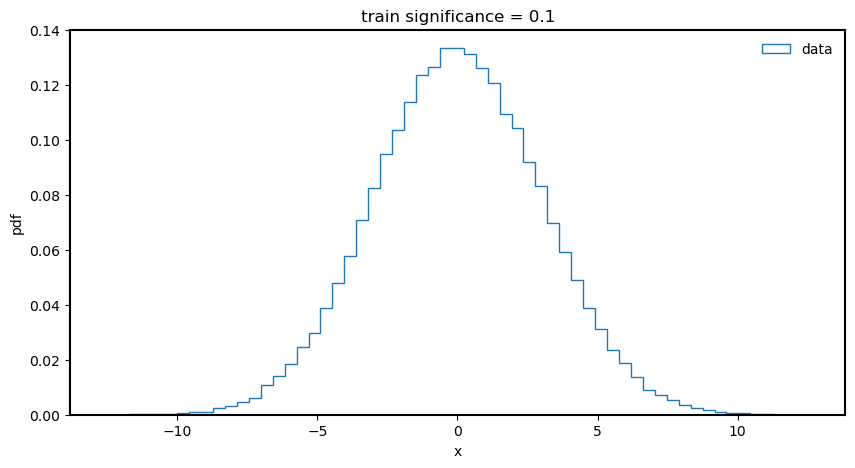

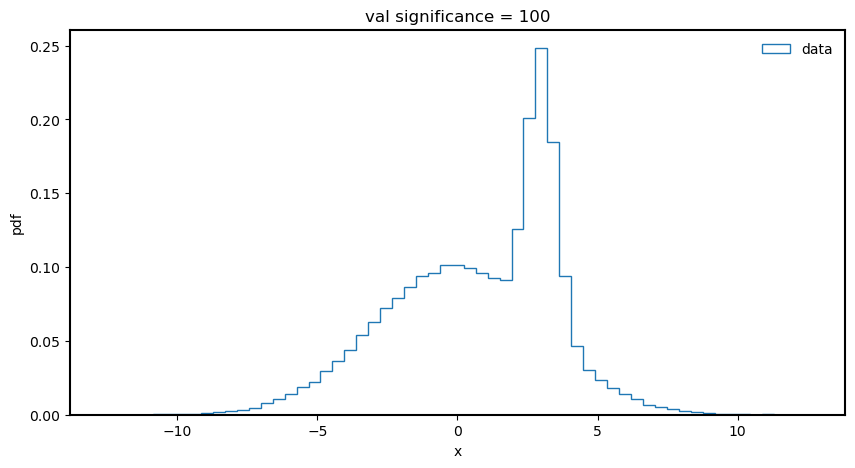

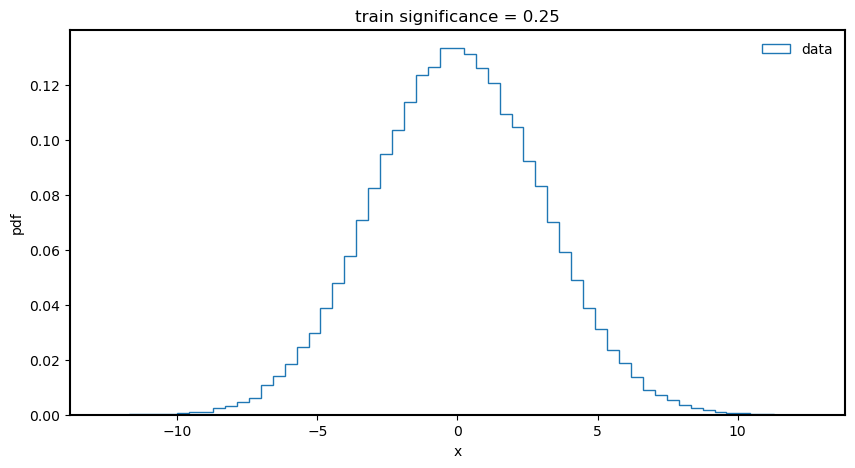

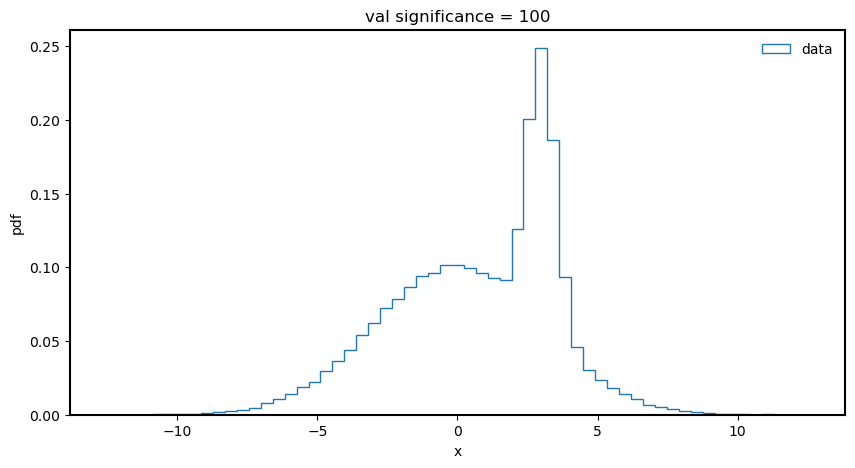

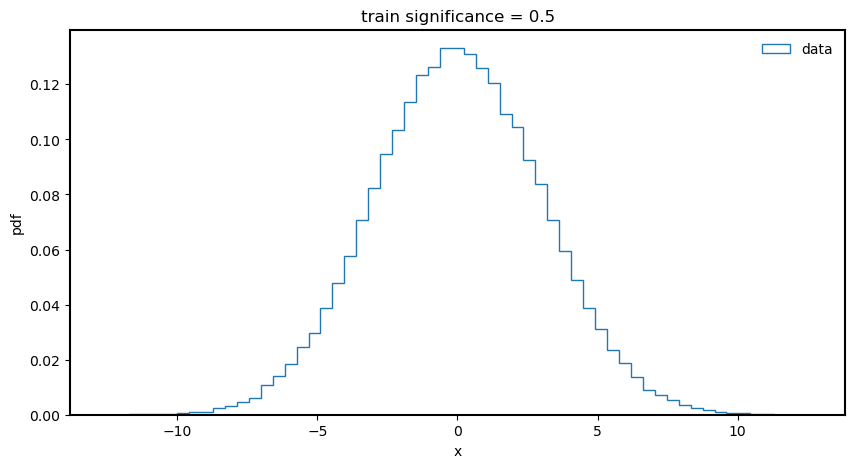

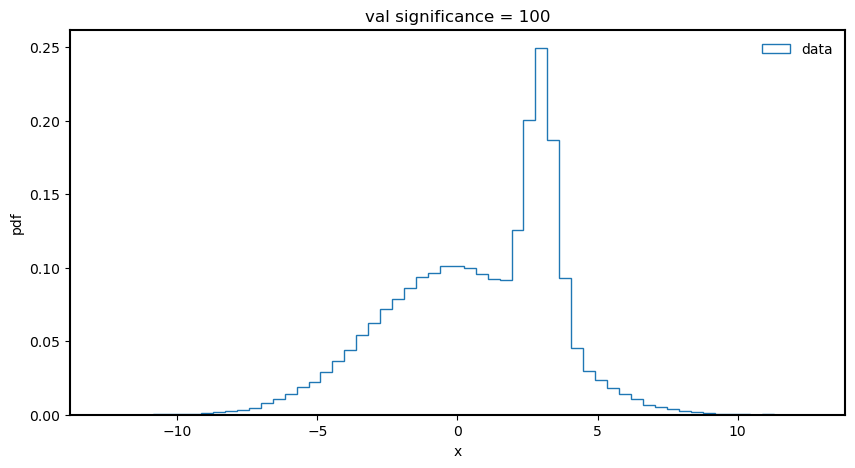

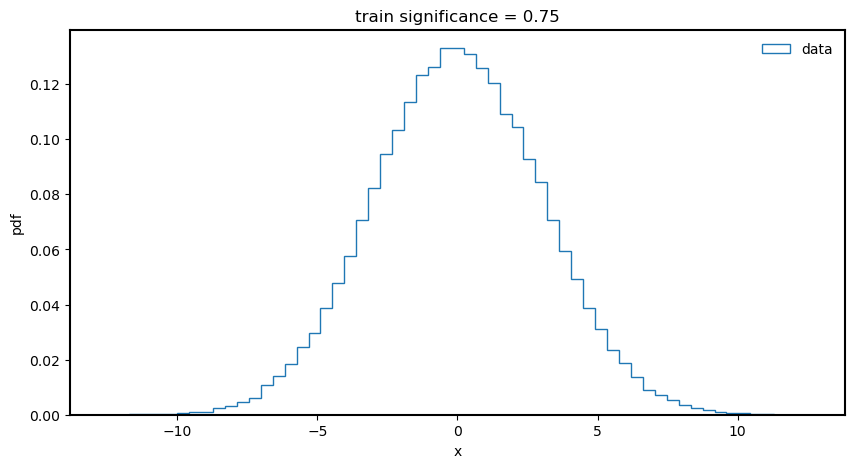

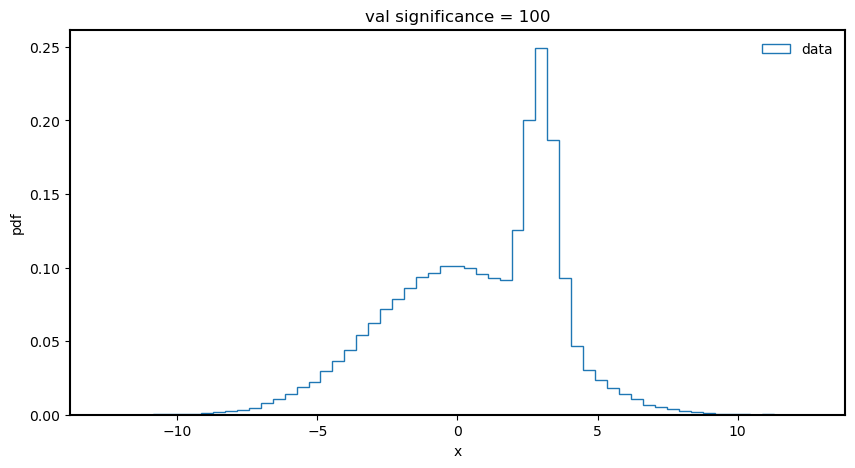

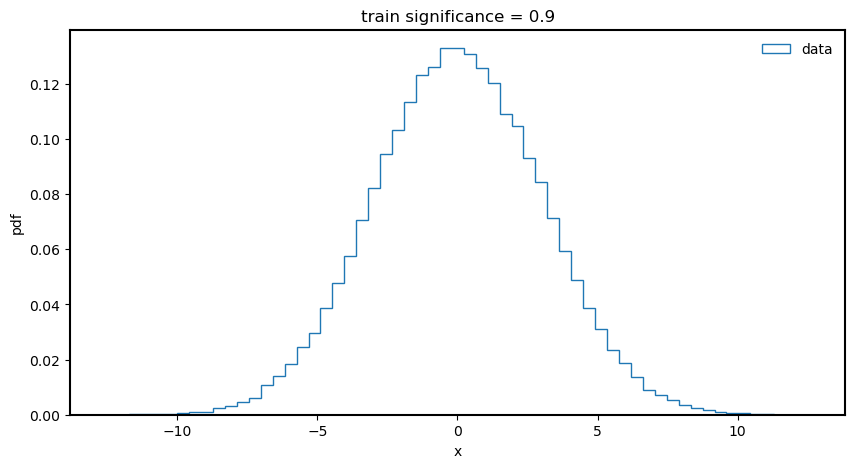

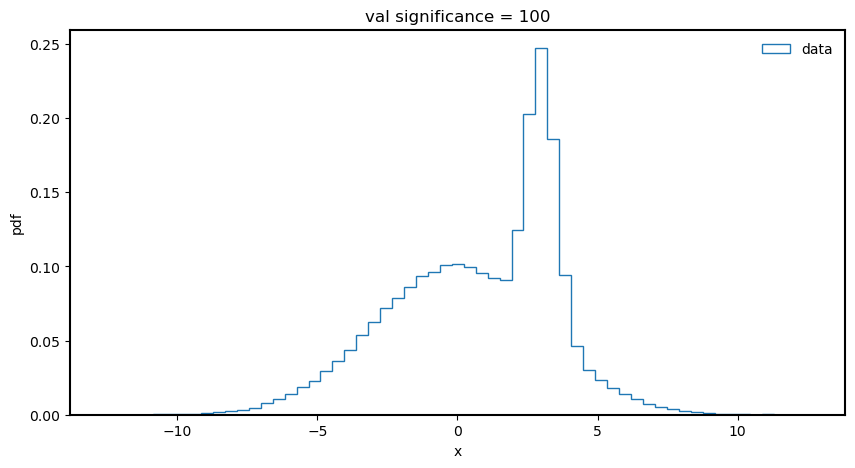

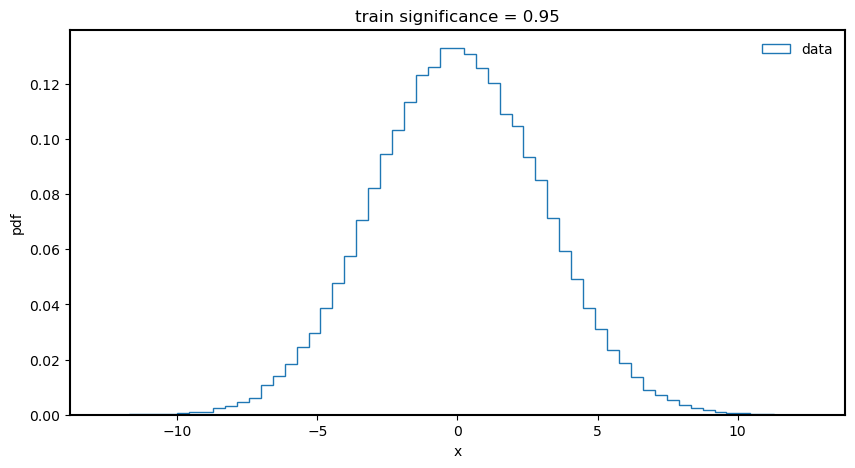

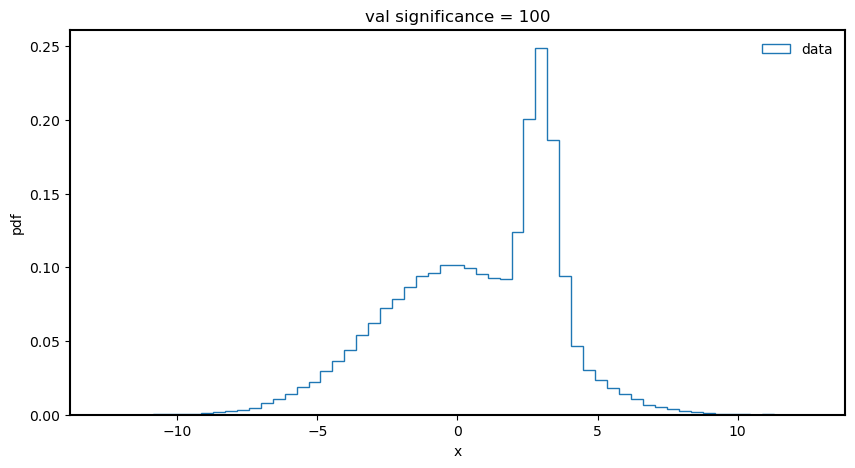

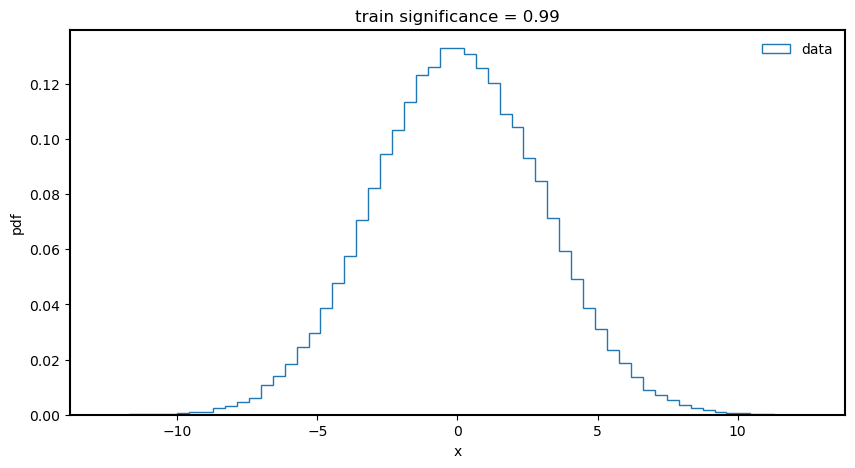

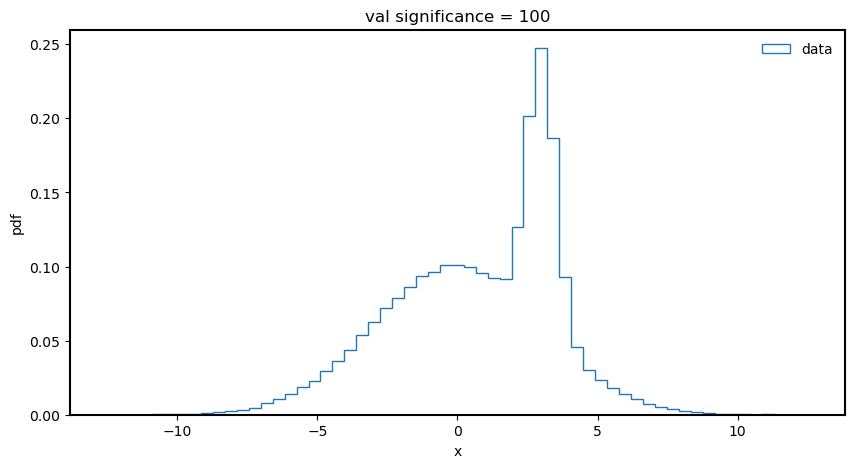

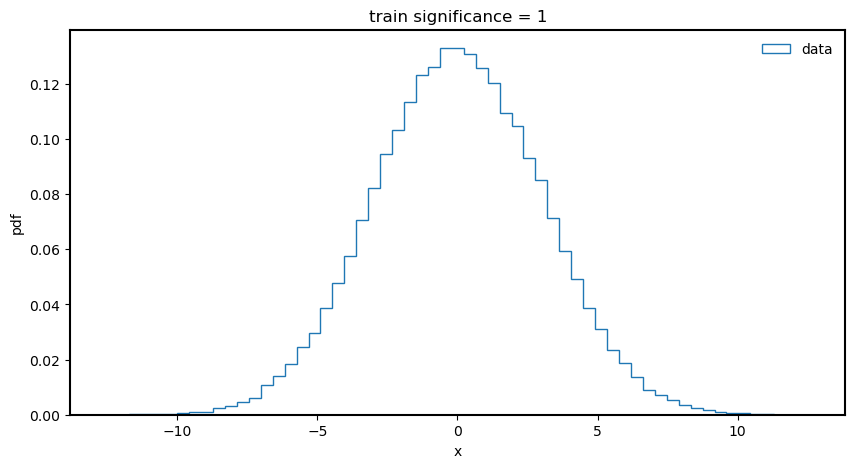

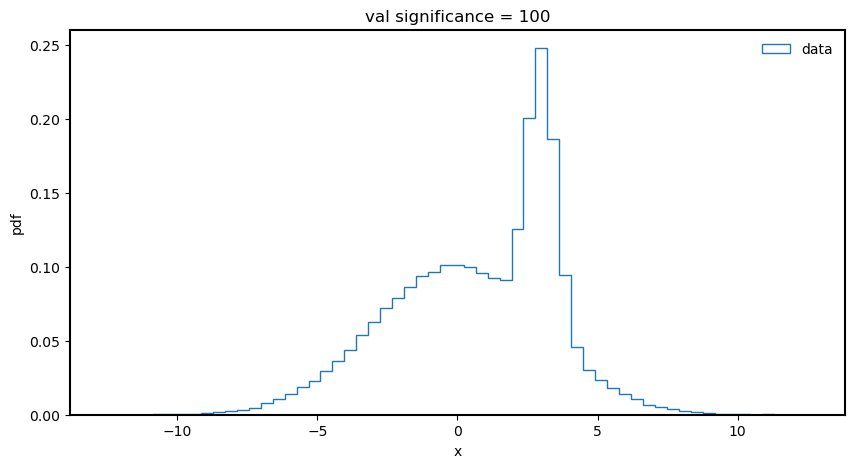

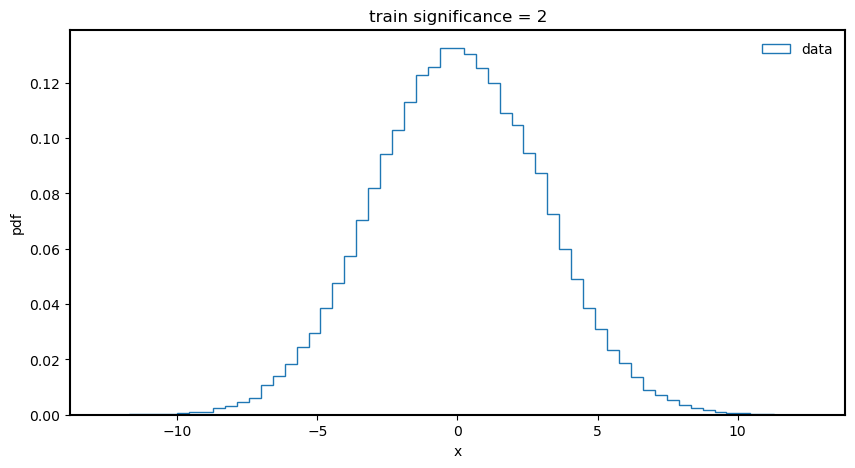

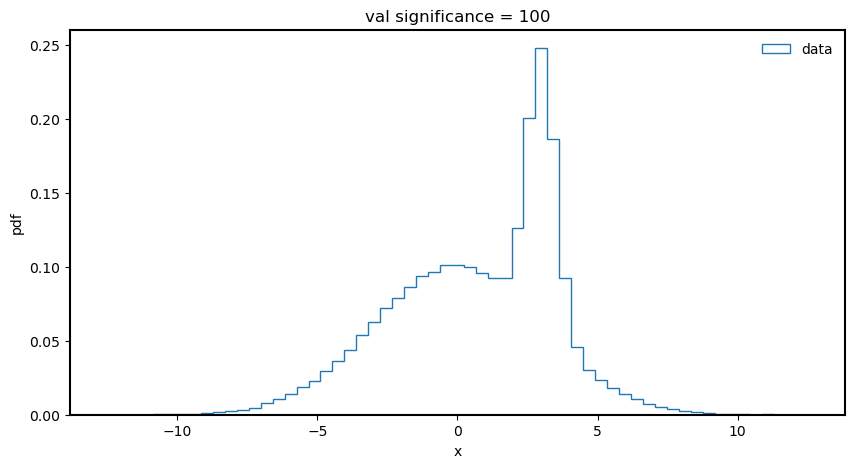

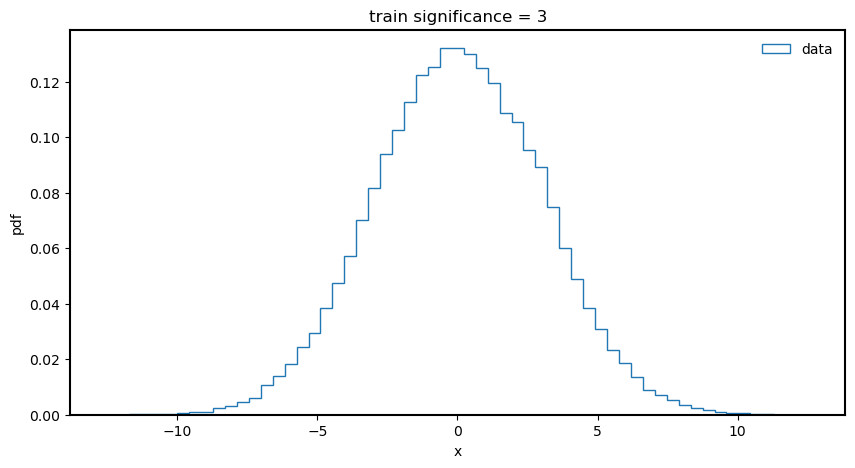

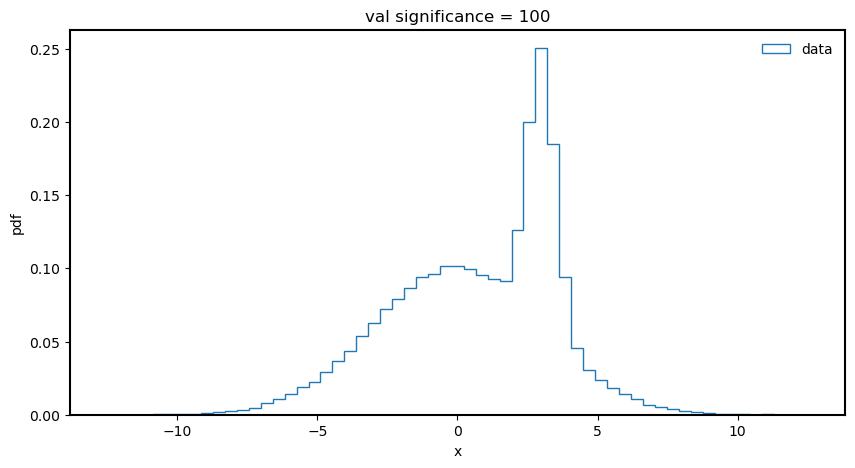

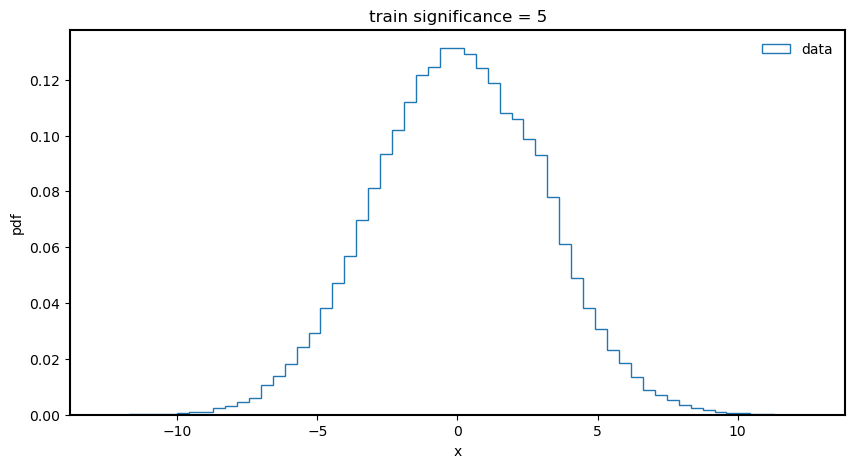

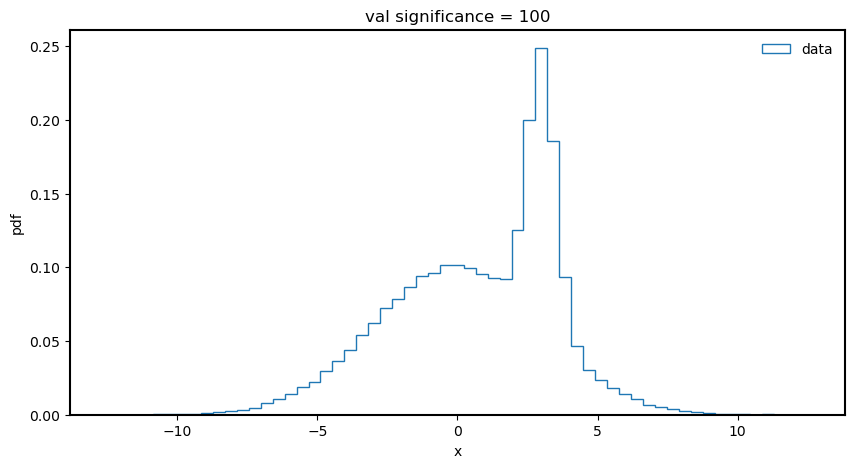

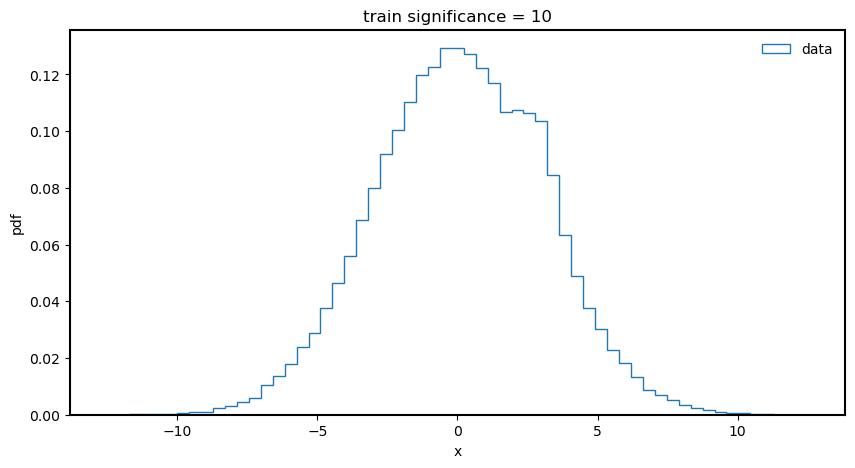

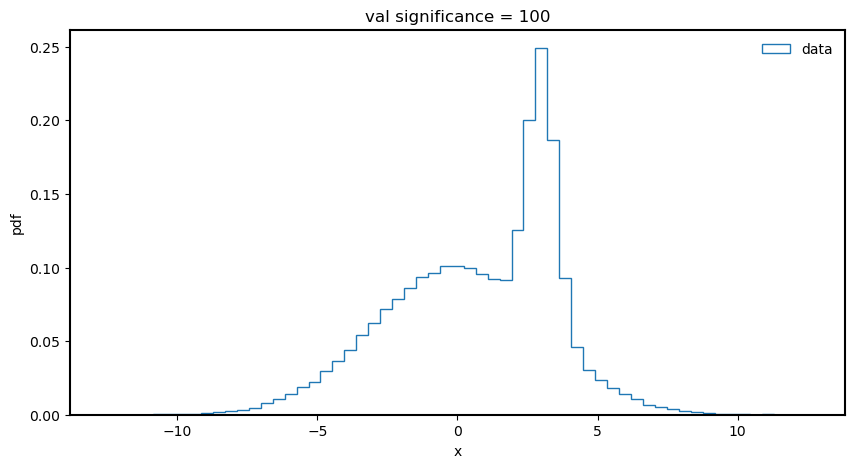

In [4]:
n_back = 100000

back_mean = 0
sig_mean = 3
sig_simga = 0.5
back_sigma = 3

split = ['train','val']
background = np.random.normal(back_mean, back_sigma, n_back)

for sig_train in sigs:


    data[str(sig_train)] = {}

    for s in split:


        if s == 'val':
            significance = 100
        else:
            significance = sig_train

        n_signal = int(np.sqrt(n_back) * significance)
        signal = np.random.normal(sig_mean, sig_simga, n_signal)
        x = np.concatenate([background, signal])
        label = np.concatenate([np.zeros(len(background)), np.ones(len(signal))])

        data[str(sig_train)][s] = {}

        data[str(sig_train)][s]['label'] = label
        data[str(sig_train)][s]['data'] = x

        bins = np.linspace(min(x.flatten()), max(x.flatten()), 60)

        plt.subplots(figsize=(10, 5))

        plt.hist(x.flatten(), bins=bins, density=True, histtype='step', label='data')
        plt.title('{} significance = {}'.format(s,significance))
        plt.legend(frameon=False)
        plt.xlabel('x')
        plt.ylabel('pdf')
        plt.show()

[0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99, 1, 2, 3, 5, 10]
0.1


/tmp/ipykernel_673561/1161027462.py:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  n_signal = int(np.sqrt(n_back) * np.float(sig_train))


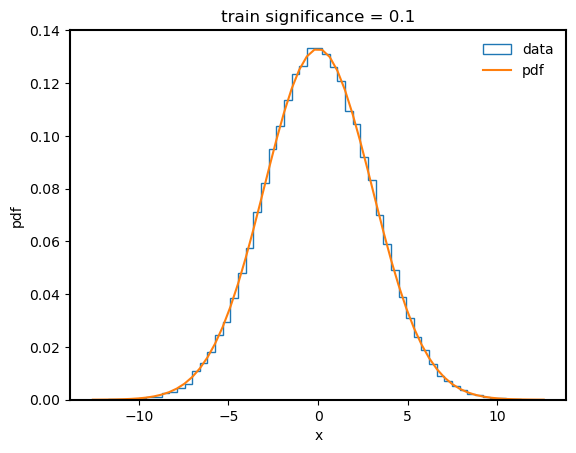

0.25


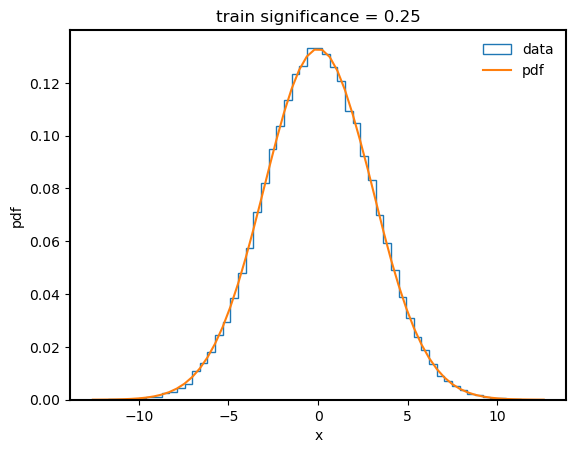

0.5


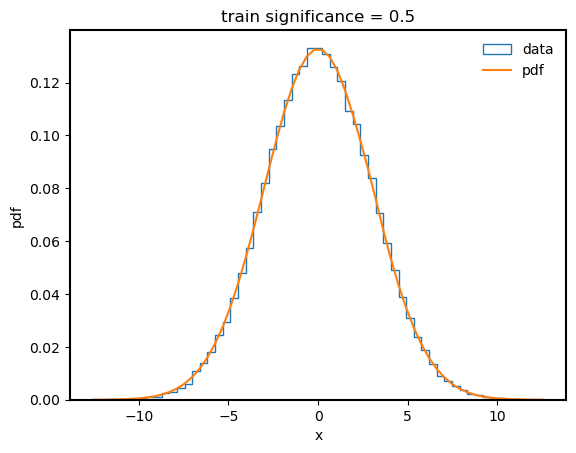

0.75


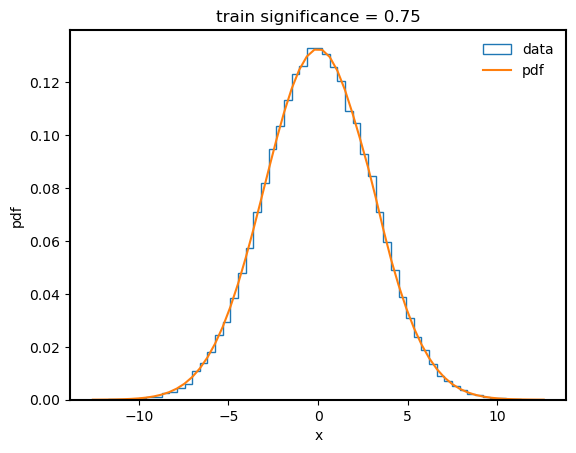

0.9


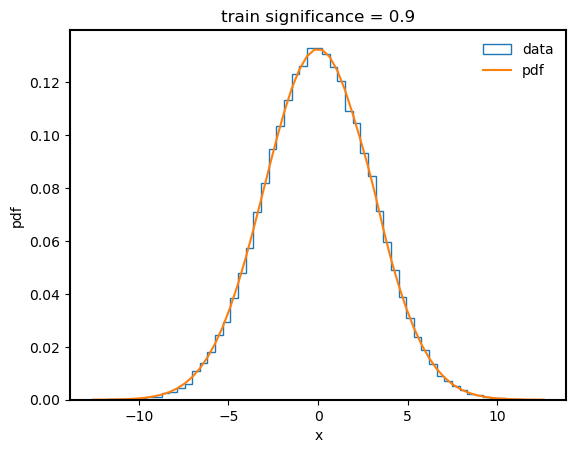

0.95


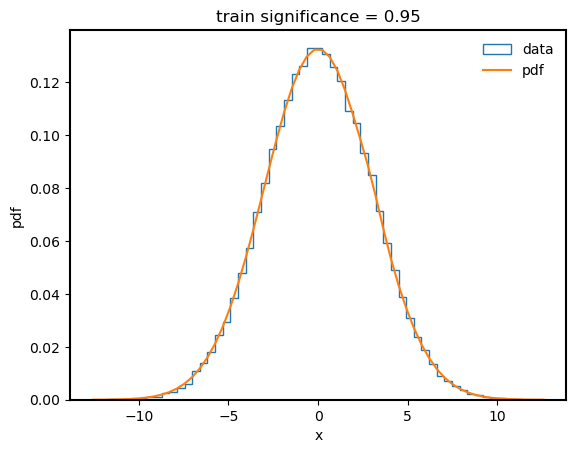

0.99


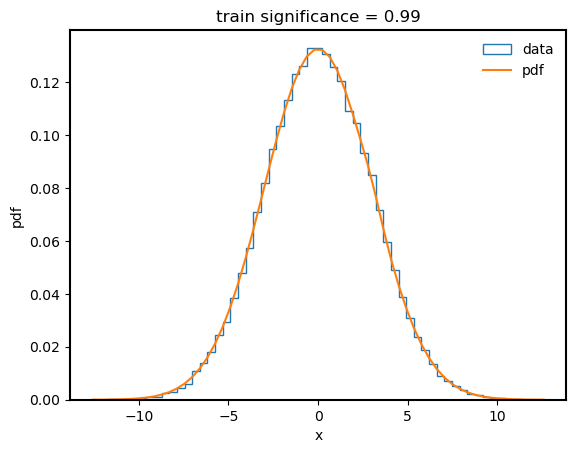

1


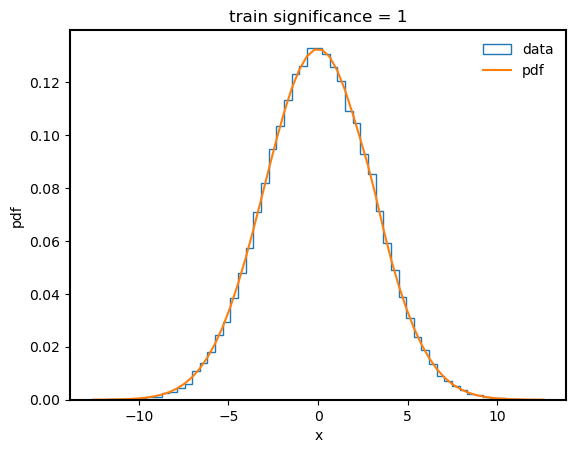

2


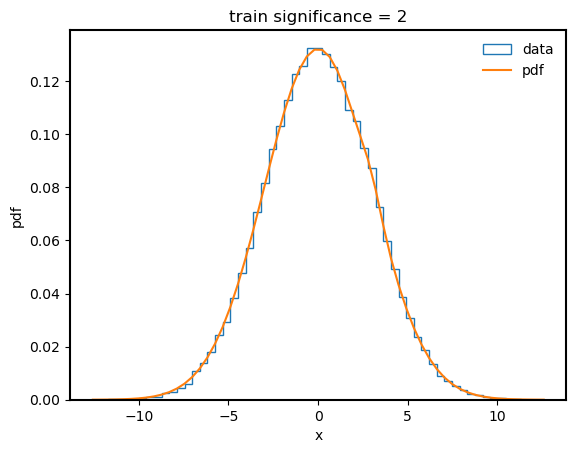

3


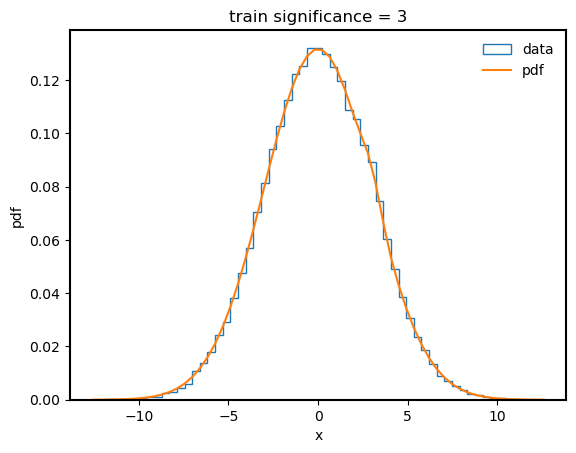

5


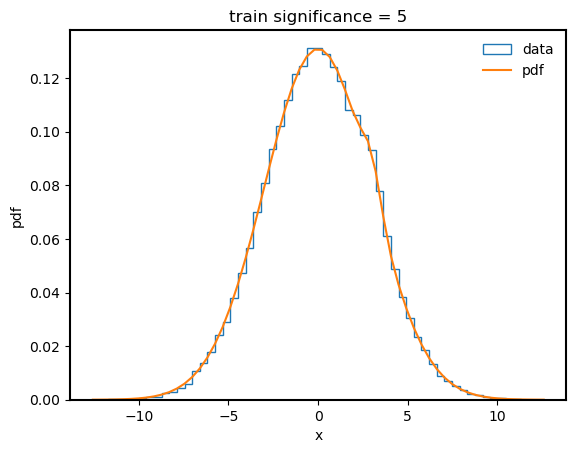

10


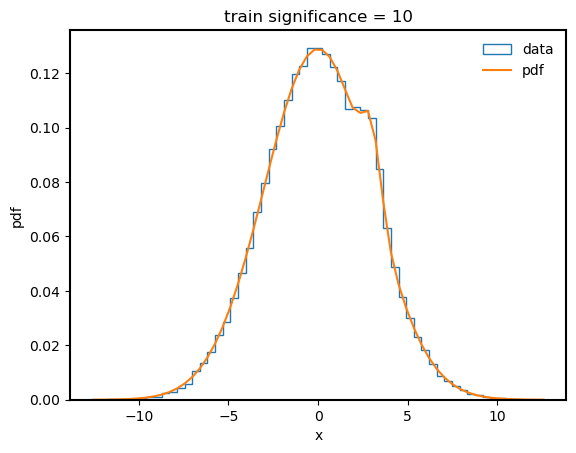

In [5]:
true_w = {}
print(sigs)
for sig_train in sigs:

    x_train = data[str(sig_train)]['train']['data']
    print(sig_train)
    bins = np.linspace(min(x_train.flatten()), max(x_train.flatten()), 60)

    n_signal = int(np.sqrt(n_back) * np.float(sig_train))
    w1 = n_signal / (n_signal + n_back)
    w2 = 1 - w1

    true_w[str(sig_train)] = [w1,w2]


    mu1 = sig_mean
    mu2 = back_mean
    sigma1 = sig_simga
    sigma2 = back_sigma



    plt.hist(x_train.flatten(), bins=bins, density=True, histtype='step', label='data')
    plt.plot(bins, w1 * norm.pdf(bins, mu1, sigma1) + w2 * norm.pdf(bins, mu2, sigma2), label='pdf')
    plt.title('{} significance = {}'.format('train',sig_train))
    plt.legend(frameon=False)
    plt.xlabel('x')
    plt.ylabel('pdf')
    plt.show()

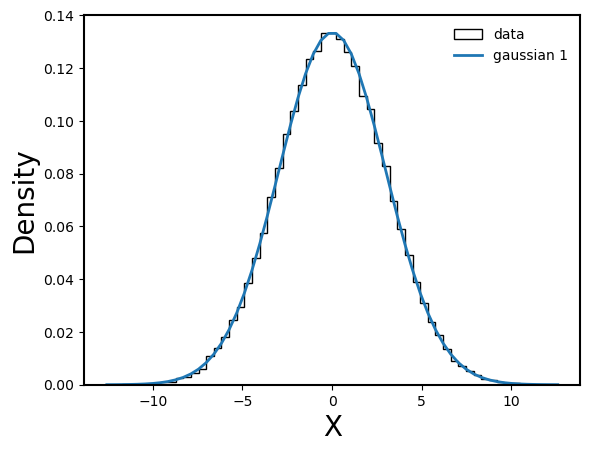

In [6]:
# Fit background only
x_train = data[str(sig_train)]['train']['data']
y_train = data[str(sig_train)]['train']['label']

x_b = x_train[y_train == 0].reshape(-1, 1)

bins = np.linspace(min(x_b.flatten()), max(x_b.flatten()), 60)
# Since the optimal value is n=2 according to both BIC and AIC, let's write down:
n_optimal = 1

# create GMM model object
gmm = GMM(n_components = n_optimal, max_iter=1000, random_state=10, covariance_type = 'full')

# find useful parameters
mean = gmm.fit(x_b).means_  
covs  = gmm.fit(x_b).covariances_
weights = gmm.fit(x_b).weights_

# create necessary things to plot
x_axis = bins
y_axis0 = norm.pdf(x_axis, float(mean[0][0]), np.sqrt(float(covs[0][0][0])))*weights[0] # 1st gaussian
#y_axis1 = norm.pdf(x_axis, float(mean[1][0]), np.sqrt(float(covs[1][0][0])))*weights[1] # 2nd gaussian

# Plot 2
plt.hist(x_b, density=True, color='black', bins=bins, histtype='step',
         label='data')
plt.plot(x_axis, y_axis0, lw=2, c='C0', label='gaussian 1')
plt.xlabel(r"X", fontsize=20)
plt.ylabel(r"Density", fontsize=20)

plt.subplots_adjust(wspace=0.3)
plt.legend(frameon=False)
plt.show()
plt.close('all')

mu_background = float(mean[0][0])
sigma_background = float(covs[0][0][0])

In [8]:
best_parameters = {}

In [9]:
# fit train data

for sig_train in sigs:
    best_parameters[str(sig_train)] = {}
    x_train = data[str(sig_train)]['train']['data']

    print('#################################')
    print
    print('Running EM algorithm for sig = {}'.format(sig_train))
    n_optimal = 2
    trial = 0
    best_likelihood = -np.inf
    convergence_ = False

    while convergence_ != True:
        trial += 1
        convergence_ ,mu_data , sigma_data, w_data, like_arr = EM_2_gaussian(x_train, n_optimal, 1000, 
                                                                             1e-40,
                                                        init_params='random',
                                                        mu_back=mu_background,
                                                        sigma_back=sigma_background)
        
        max_likelihood = np.argmax(like_arr)

        #print(' max likelihood = ', like_arr[max_likelihood])
        #print('likelihood diff = ', like_arr[-1]-like_arr[-2])

        mu_ = mu_data[max_likelihood]
        sigma_ = sigma_data[max_likelihood]
        w_ = w_data[max_likelihood]
        x_axis = bins

    

        if like_arr[max_likelihood] > best_likelihood:
            best_likelihood = like_arr[max_likelihood]
            best_mu = mu_
            best_sigma = sigma_
            best_w = w_
            best_trial = trial
            best_like_arr = like_arr


            best_parameters[str(sig_train)]['mu'] = best_mu
            best_parameters[str(sig_train)]['sigma'] = best_sigma
            best_parameters[str(sig_train)]['w'] = best_w
            

        if trial > 100:
            break

    if convergence_ == True:
        print('Converged after {} trials'.format(trial))
    else:
        print('Did not converge after {} trials'.format(trial))
        print('Best trial was {}'.format(best_trial))





#################################
Running EM algorithm for sig = 0.1
Did not converge after 999 iterations.
Did not converge after 999 iterations.
Did not converge after 999 iterations.
Did not converge after 999 iterations.
Did not converge after 999 iterations.
Did not converge after 999 iterations.
Did not converge after 999 iterations.
Did not converge after 999 iterations.
Did not converge after 999 iterations.
Did not converge after 999 iterations.


/home/rd804/m-anode/src/utils.py:121: RuntimeWarning: divide by zero encountered in log
  log_likelihood = np.log(p_c1 + p_c2).sum()
/home/rd804/m-anode/src/utils.py:30: RuntimeWarning: invalid value encountered in divide
  return numerator / denominator


Did not converge after 999 iterations.
Did not converge after 999 iterations.
Did not converge after 999 iterations.
Converged after 83 iterations.
Converged after 14 trials
#################################
Running EM algorithm for sig = 0.25
Did not converge after 999 iterations.
Did not converge after 999 iterations.
Did not converge after 999 iterations.
Did not converge after 999 iterations.
Did not converge after 999 iterations.
Did not converge after 999 iterations.
Did not converge after 999 iterations.
Did not converge after 999 iterations.
Did not converge after 999 iterations.
Did not converge after 999 iterations.
Did not converge after 999 iterations.
Did not converge after 999 iterations.
Did not converge after 999 iterations.
Did not converge after 999 iterations.
Did not converge after 999 iterations.
Did not converge after 999 iterations.
Did not converge after 999 iterations.
Did not converge after 999 iterations.
Did not converge after 999 iterations.
Did not converg

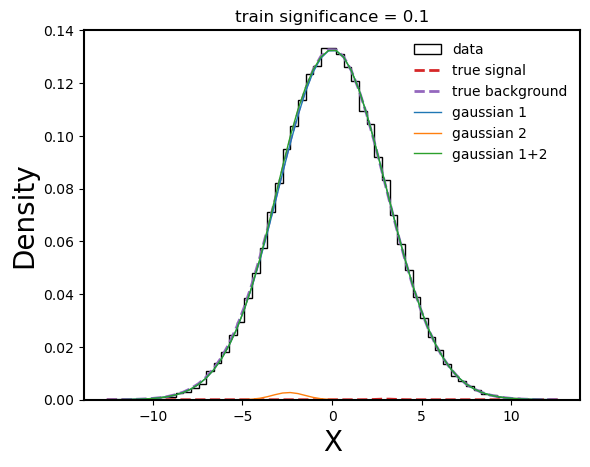

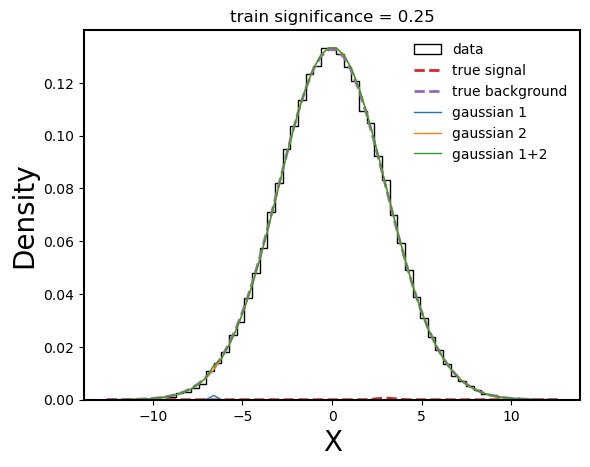

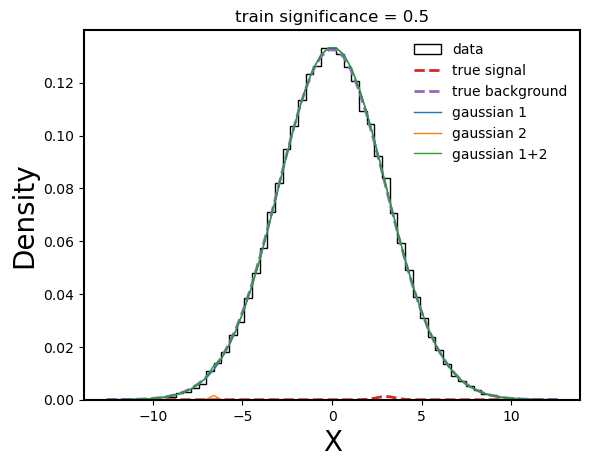

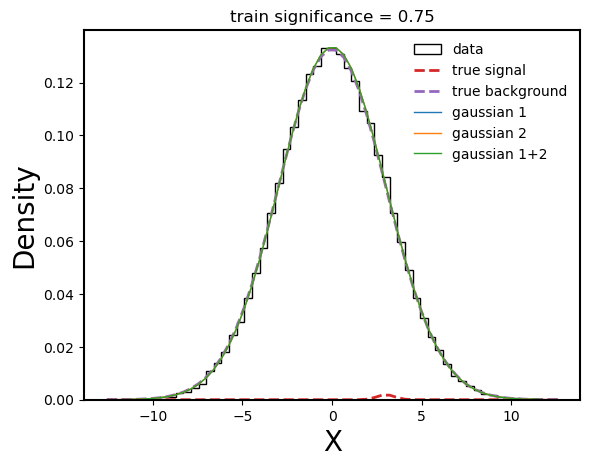

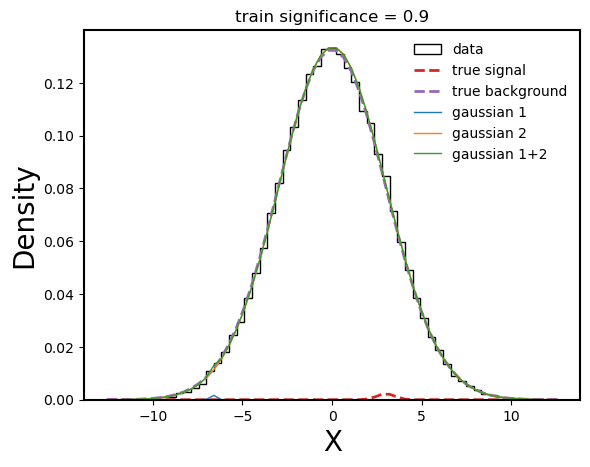

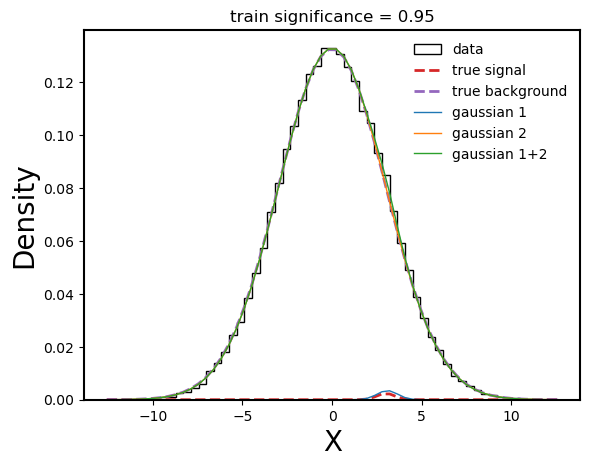

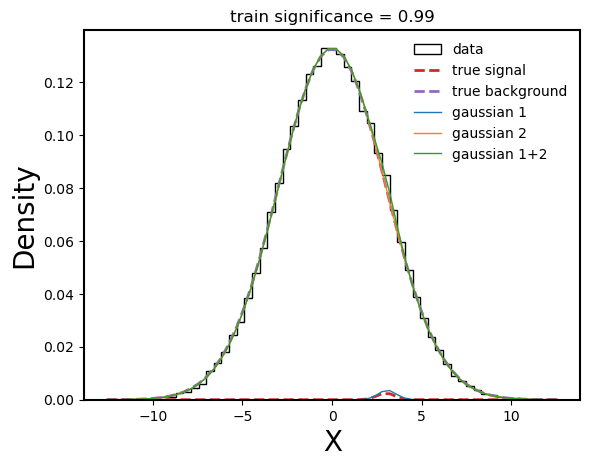

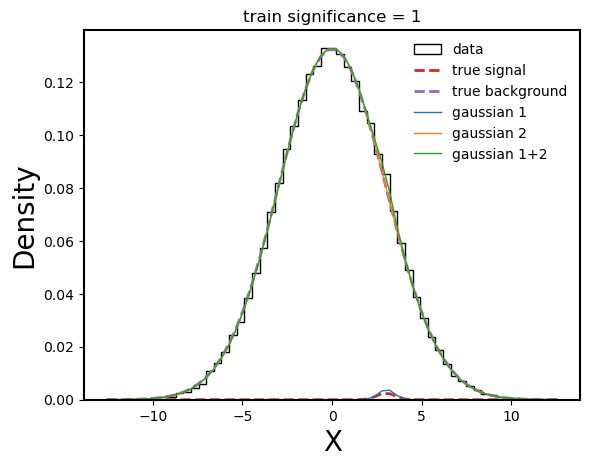

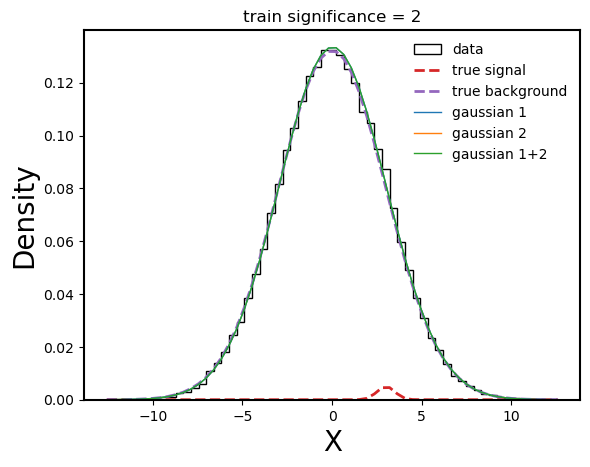

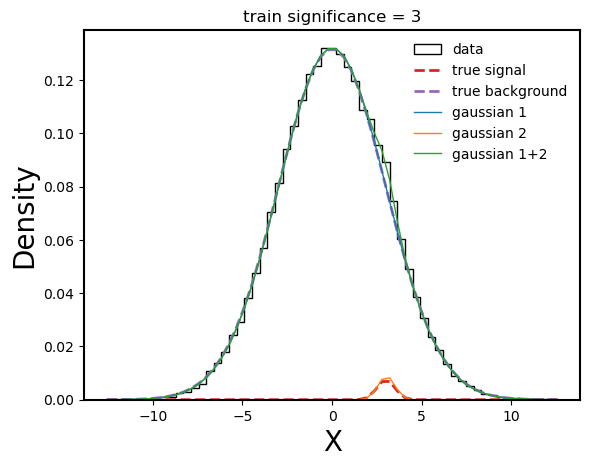

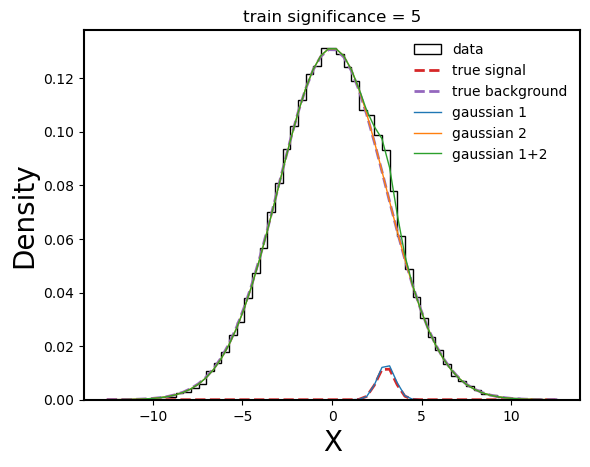

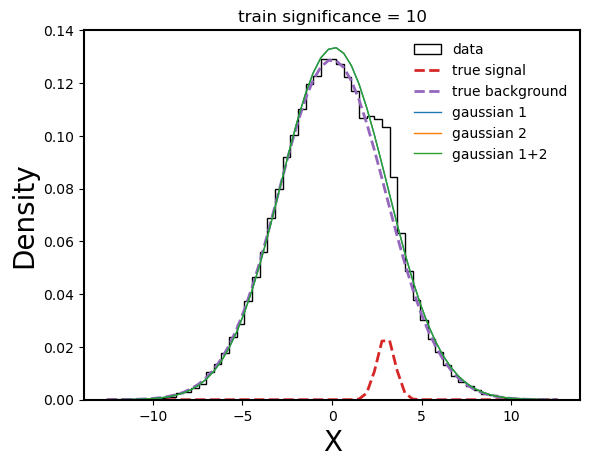

In [14]:
for sig_train in sigs:

    x_train = data[str(sig_train)]['train']['data']
    bins = np.linspace(min(x_train.flatten()), max(x_train.flatten()), 60)

    w1 = true_w[str(sig_train)][0]
    w2 = true_w[str(sig_train)][1]
    true_sig = norm.pdf(x_axis, sig_mean, sig_simga)*w1
    true_back = norm.pdf(x_axis, back_mean, back_sigma)*w2

    mu_ = best_parameters[str(sig_train)]['mu']
    sigma_ = best_parameters[str(sig_train)]['sigma']
    w_ = best_parameters[str(sig_train)]['w']


    plt.hist(x_train, density=True, color='black', bins=bins, histtype='step',
                label='data')
    plt.plot(x_axis, true_sig, lw=2, c='C3', label='true signal',ls='--')
    plt.plot(x_axis, true_back, lw=2, c='C4', label='true background', ls='--')
    plt.plot(x_axis, w_[0] * norm.pdf(x_axis, mu_[0], np.sqrt(sigma_[0])), lw=1, c='C0', label='gaussian 1')
    plt.plot(x_axis, w_[1] * norm.pdf(x_axis, mu_[1], np.sqrt(sigma_[1])), lw=1, c='C1', label='gaussian 2')
    plt.plot(x_axis, w_[0] * norm.pdf(x_axis, mu_[0], np.sqrt(sigma_[0])) + w_[1] * norm.pdf(x_axis, mu_[1], np.sqrt(sigma_[1])), lw=1, c='C2', label='gaussian 1+2')
    plt.title('{} significance = {}'.format('train',sig_train))
    plt.xlabel(r"X", fontsize=20)
    plt.ylabel(r"Density", fontsize=20)
    plt.legend(frameon=False)
    plt.show()

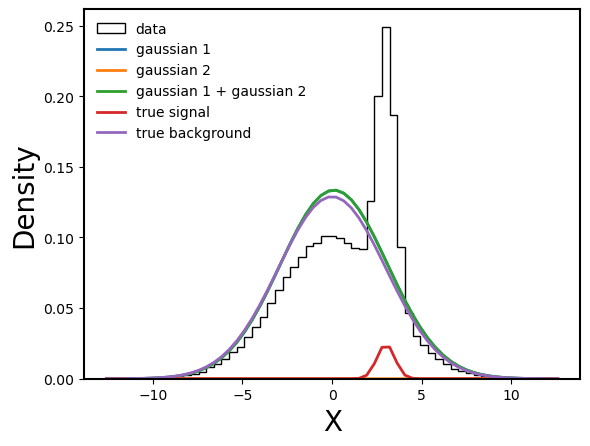

In [11]:
x_val = data[str(sig_train)]['val']['data']
label_val = data[str(sig_train)]['val']['label']

bins = np.linspace(min(x_val.flatten()), max(x_val.flatten()), 60)
max_likelihood = np.argmax(like_arr)

mu_ = mu_data[max_likelihood]
sigma_ = sigma_data[max_likelihood]
w_ = w_data[max_likelihood]
x_axis = bins

true_sig = norm.pdf(x_axis, mu1, sigma1)*w1
true_back = norm.pdf(x_axis, mu2, sigma2)*w2

plt.hist(x_val, density=True, color='black', bins=bins, histtype='step',
            label='data')
plt.plot(x_axis, norm.pdf(x_axis, mu_[0], np.sqrt(sigma_[0]))*w_[0], lw=2, c='C0', label='gaussian 1')
plt.plot(x_axis, norm.pdf(x_axis, mu_[1], np.sqrt(sigma_[1]))*w_[1], lw=2, c='C1', label='gaussian 2')
plt.plot(x_axis, norm.pdf(x_axis, mu_[0], np.sqrt(sigma_[0]))*w_[0] + norm.pdf(x_axis, mu_[1], np.sqrt(sigma_[1]))*w_[1], lw=2, c='C2', label='gaussian 1 + gaussian 2')
plt.plot(x_axis, true_sig, lw=2, c='C3', label='true signal')
plt.plot(x_axis, true_back, lw=2, c='C4', label='true background')
plt.xlabel(r"X", fontsize=20)
plt.ylabel(r"Density", fontsize=20)
plt.legend(frameon=False)
plt.show()

In [12]:
score_likelihoods = {}
true_likelihoods = {}

for sig_train in sigs:
    x_val = data[str(sig_train)]['val']['data']
    label_val = data[str(sig_train)]['val']['label']

    mu = best_parameters[str(sig_train)]['mu']
    sigma = best_parameters[str(sig_train)]['sigma']
    w = best_parameters[str(sig_train)]['w']


    w1 = true_w[str(sig_train)][0]
    w2 = true_w[str(sig_train)][1]

    score_likelihoods[str(sig_train)] = p_data(x_val,mu,sigma,w)/p_back(x_val,mu_background,sigma_background)
    true_likelihoods[str(sig_train)] = p_data(x_val,[sig_mean, back_mean],[sig_simga**2,back_sigma**2],[w1,w2])/p_back(x_val,back_mean,back_sigma**2)

    print('#################################')
    print('sig = {}'.format(sig_train))
    print(mu_background,sigma_background)
    print(mu,sigma,w)
    print(sig_mean, back_mean)
    print(sig_simga,back_sigma)
    print(w1,w2)




#################################
sig = 0.1
0.01181752993320802 8.930698630997036
[ 0.02789963 -2.41674993] [8.94438441 0.81844541] [0.99380656 0.00619344]
3 0
0.5 3
0.00030990392978176763 0.9996900960702182
#################################
sig = 0.25
0.01181752993320802 8.930698630997036
[-6.63969243  0.01866825] [0.02783947 8.90566491] [6.93206451e-04 9.99306794e-01]
3 0
0.5 3
0.0007893763926498066 0.9992106236073502
#################################
sig = 0.5
0.01181752993320802 8.930698630997036
[ 0.02124976 -6.63971678] [8.90660082 0.02806055] [9.99299807e-01 7.00193008e-04]
3 0
0.5 3
0.001577507538089818 0.9984224924619102
#################################
sig = 0.75
0.01181752993320802 8.930698630997036
[11.20418784  0.0182328 ] [4.83000663e-03 8.92435815e+00] [6.34353842e-05 9.99936565e-01]
3 0
0.5 3
0.00236439638057803 0.9976356036194219
#################################
sig = 0.9
0.01181752993320802 8.930698630997036
[-6.63980105  0.02505241] [0.02854392 8.90607129] [7.14053

/home/rd804/m-anode/src/utils.py:12: RuntimeWarning: invalid value encountered in divide
  sic = tpr/np.sqrt(fpr)
/home/rd804/m-anode/src/utils.py:12: RuntimeWarning: divide by zero encountered in divide
  sic = tpr/np.sqrt(fpr)
/home/rd804/m-anode/src/utils.py:12: RuntimeWarning: invalid value encountered in divide
  sic = tpr/np.sqrt(fpr)
/home/rd804/m-anode/src/utils.py:12: RuntimeWarning: invalid value encountered in divide
  sic = tpr/np.sqrt(fpr)
/home/rd804/m-anode/src/utils.py:12: RuntimeWarning: divide by zero encountered in divide
  sic = tpr/np.sqrt(fpr)
/home/rd804/m-anode/src/utils.py:12: RuntimeWarning: invalid value encountered in divide
  sic = tpr/np.sqrt(fpr)
/home/rd804/m-anode/src/utils.py:12: RuntimeWarning: invalid value encountered in divide
  sic = tpr/np.sqrt(fpr)
/home/rd804/m-anode/src/utils.py:12: RuntimeWarning: invalid value encountered in divide
  sic = tpr/np.sqrt(fpr)
/home/rd804/m-anode/src/utils.py:12: RuntimeWarning: invalid value encountered in divi

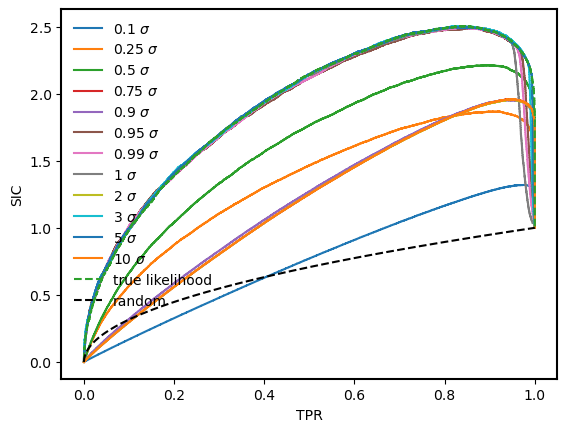

In [13]:

for sig_train in sigs:
    sic , tpr , auc = SIC(label_val, score_likelihoods[str(sig_train)])
    sic_true , tpr_true , auc_true = SIC(label_val, true_likelihoods[str(sig_train)])

    plt.plot(tpr, sic, label=f'{sig_train} $\sigma$')
plt.plot(tpr_true, sic_true, label='true likelihood', ls='--')

plt.plot(tpr_true, tpr_true**0.5, label='random', color='black', ls='--')
plt.xlabel('TPR')
plt.ylabel('SIC')
plt.legend(frameon=False)
plt.savefig('results/sic.pdf')
plt.show()


/home/rd804/m-anode/src/utils.py:12: RuntimeWarning: divide by zero encountered in divide
  sic = tpr/np.sqrt(fpr)
/home/rd804/m-anode/src/utils.py:12: RuntimeWarning: invalid value encountered in divide
  sic = tpr/np.sqrt(fpr)
/home/rd804/m-anode/src/utils.py:12: RuntimeWarning: divide by zero encountered in divide
  sic = tpr/np.sqrt(fpr)
/home/rd804/m-anode/src/utils.py:12: RuntimeWarning: invalid value encountered in divide
  sic = tpr/np.sqrt(fpr)


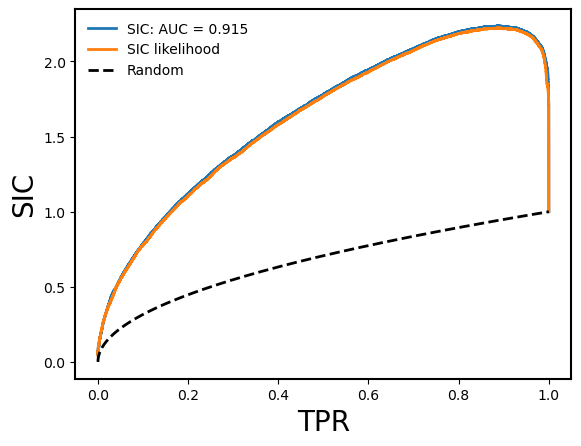

In [19]:
#sic_2, tpr_2, auc_2 = SIC(label_val, score)


sic_10, tpr_10, auc_10 = SIC(label_val, score)

sic_likelihood, tpr_likelihood, auc_likelihood = SIC(label_val, score_likelihood)

#plt.plot(tpr_2, sic_2, lw=2, c='C0', label='SIC: AUC = {:.3f}'.format(auc_2))
plt.plot(tpr_10, sic_10, lw=2, c='C0', label='SIC: AUC = {:.3f}'.format(auc_10))
#plt.plot(tpr_100, sic_100, lw=2, c='C0', label='SIC: AUC = {:.3f}'.format(auc_100))
plt.plot(tpr_likelihood, sic_likelihood, lw=2, c='C1', label='SIC likelihood')
plt.plot(tpr_likelihood, tpr_likelihood**0.5, lw=2, c='black', label='Random', ls='--')
plt.xlabel(r"TPR", fontsize=20)
plt.ylabel(r"SIC", fontsize=20)
plt.legend(frameon=False)
plt.show()